In [59]:
import xarray as xr
import pandas as pd
import numpy as np
import warnings
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
ds=xr.open_mfdataset(
    '/g/data/oe9/user/rg6346/VI_mask_nc/NDVI/NDVI_????.nc',
    chunks=dict(long=176)) 
ds=ds.rename({'ndvi_evi':'ndvi'})
ds=ds.drop('band')
ds['ndvi']=ds.ndvi/10000;
ds

<xarray.Dataset>
Dimensions:  (lat: 3147, long: 3344, time: 388)
Coordinates:
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 dask.array<shape=(388, 3147, 3344), chunksize=(20, 3147, 176)>

## Subset data for testing

In [53]:
sub=ds.sel(lat=slice(-30.1, -31),long=slice(148.9,150.6)) ##yarrie
sub.load()

<xarray.Dataset>
Dimensions:  (lat: 216, long: 408, time: 388)
Coordinates:
  * lat      (lat) float64 -30.1 -30.11 -30.11 -30.11 -30.12 -30.12 -30.13 ...
  * long     (long) float64 148.9 148.9 148.9 148.9 148.9 148.9 148.9 148.9 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 0.3499 0.3152 0.2693 0.2616 0.2476 ...

In [54]:
ndvi_q=sub.ndvi.resample(time='Q-FEB').mean(dim='time')
ndvi_jja=ndvi_q.where(ndvi_q['time.season']=='JJA',drop=True)
ndvi_djf=ndvi_q.where(ndvi_q['time.season']=='DJF',drop=True)

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


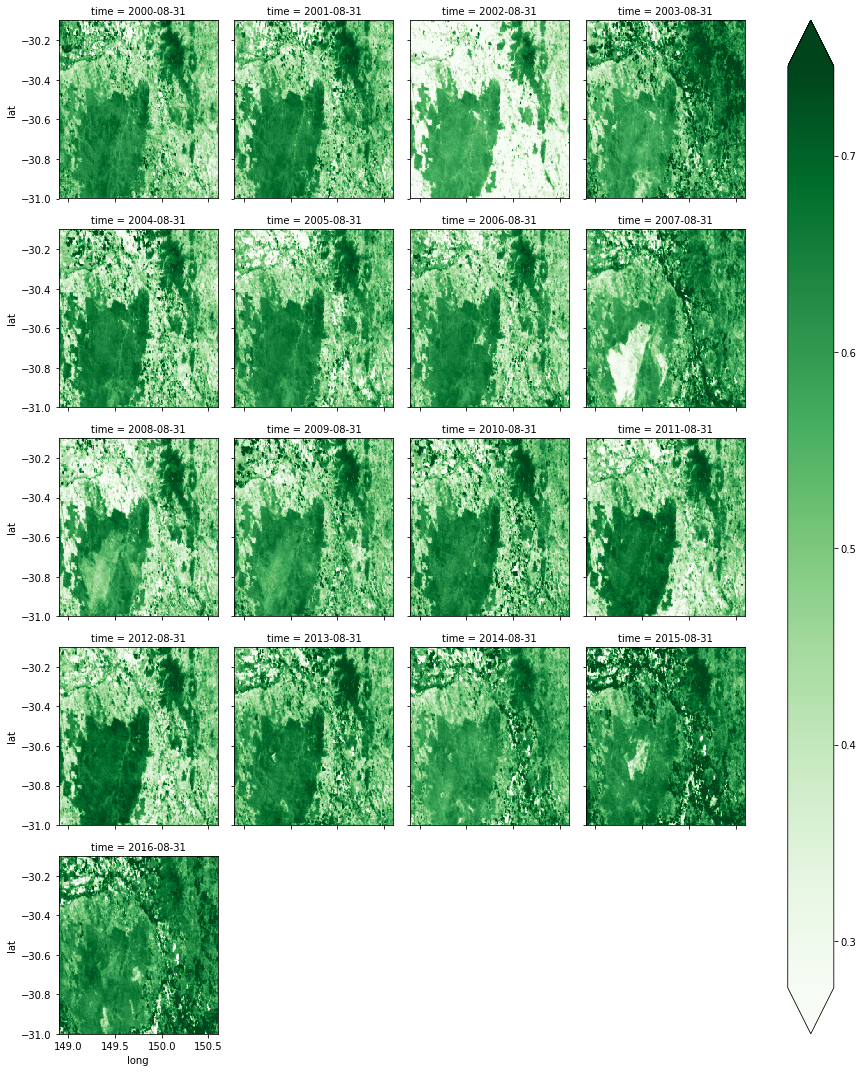

In [55]:
ndvi_jja.plot.imshow(col='time', robust=True,cmap='Greens',col_wrap=4)

## Calculate and plot seasonal variance

In [17]:

ndvi_jja_std=ndvi_jja.std(dim='time')
ndvi_djf_std=ndvi_djf.std(dim='time')


<IPython.core.display.Javascript object>


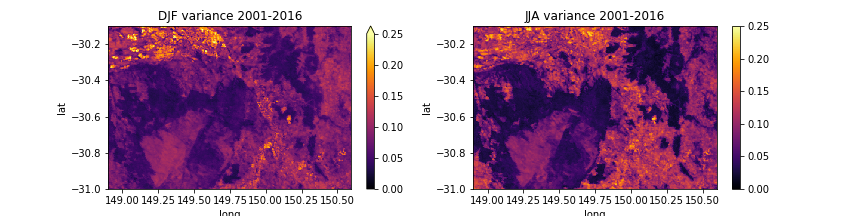

Text(0.5,1,'JJA variance 2001-2016')

In [50]:
cmap='inferno'
vmin=0
vmax=.25
fig=plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
ndvi_djf_std.plot(cmap=cmap,vmin=vmin, vmax=vmax)
plt.title('DJF variance 2001-2016')
plt.subplot(1,2,2)
ndvi_jja_std.plot(cmap=cmap,vmin=vmin, vmax=vmax)
plt.title('JJA variance 2001-2016')

## Linear regression

In [60]:
data=sub.ndvi
# def linregress(data):
    data['days_since'] = (data.time - data.time[0] ).astype(np.float)
    mask = ~np.isnan(data) & ~np.isnan(data.days_since)
    slope, intercept, r_sq, p_values, std_err = stats.linregress(data.days_since[mask],data[mask])
#     out = rainfall_data.copy()
    
    
#     if isinstance(rainfall_data, xr.DataArray):
#         rainfall_data = rainfall_data.values
    
#     #loc_NaNs = isnan(rainfall_data)
#     #rainfall_data[loc_NaNs] = 0
#     # Initialize SPI class
#     spi = SPI() 
#     # Set rolling window parameters
#     spi.set_rolling_window_params(span=3, window_type='blackman', center=True)
#     # Set distribution parameters
#     spi.set_distribution_params(dist_type='gamma')
#     # Calculate SPI
#     out[:] = spi.calculate(rainfall_data, starting_month=1).squeeze()
#     return out

# SPI_data = xr.apply_ufunc(
#     calc_spi,
#     Rain_month.rainfall,
#     input_core_dims=[('time',)],
#     output_core_dims=[('dim0',)],
#     vectorize=True,
    
# )

IndexError: 3-dimensional boolean indexing is not supported. 

In [ ]:
##need to adjust to do all pixels with ufunc
sub_dot=sub.sel(lat=-34.8,lon=150)
sub_dot
mask = ~np.isnan(sub_dot.ndvi) & ~np.isnan(sub_dot.days_since)
slope, intercept, r_sq, p_values, std_err = stats.linregress(sub_dot.days_since[mask],sub_dot.ndvi[mask])

In [56]:

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(sub.ndvi)


print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

ModuleNotFoundError: No module named 'sklearn'